In [1]:
from influxdb_client import InfluxDBClient

import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [10]:
days = '9d'
n_days = 9

queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  ''' % days

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  ''' % days

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  ''' % days

queryPeople = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "people")
  |> filter(fn: (r) => r["device"] == "peopleCounter")
  |> toFloat()
  |> aggregateWindow(every: 5m, fn: median)
  |> yield(name: "median")
  ''' % days

# Query InfluxDB and return a Dataframe

In [6]:
dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)

In [7]:
dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)

In [8]:
dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

In [11]:
dfPeople = client.query_api().query_data_frame(org=my_org, query=queryPeople)

In [12]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df['people'] = dfPeople['_value']
df = df.set_index('time')
df = df.asfreq(freq='300S')
df.head()

,temperature,humidity,pressure,people
time,,,,
2020-07-07 12:10:00+00:00,29.25,46.9,NaN,NaN
2020-07-07 12:15:00+00:00,NaN,NaN,NaN,NaN
2020-07-07 12:20:00+00:00,NaN,46.8,NaN,NaN
2020-07-07 12:25:00+00:00,NaN,NaN,NaN,NaN
2020-07-07 12:30:00+00:00,29.40,46.5,NaN,0.0


In [ ]:
points_per_day = int(len(df)/n_days) 

df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')
df['people'] = df['people'].fillna(method='backfill').fillna(method='ffill')

print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())
print(df['people'].isnull().sum())

In [15]:
df.head()

,temperature,humidity,pressure,people
time,,,,
2020-07-07 12:10:00+00:00,29.25,46.9,1019.5,0.0
2020-07-07 12:15:00+00:00,29.40,46.8,1019.5,0.0
2020-07-07 12:20:00+00:00,29.40,46.8,1019.5,0.0
2020-07-07 12:25:00+00:00,29.40,46.5,1019.5,0.0
2020-07-07 12:30:00+00:00,29.40,46.5,1019.5,0.0


# Save Dataframe

In [14]:
df.to_csv("dataframe.csv")
df.to_pickle("dataframe.pkl")

In [10]:
# divide in train e test
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [14]:
model_t = SARIMAX(df_train.temperature, order = (1,1,2), seasonal_order = (0,1,0,144))
results_t = model_t.fit()
results_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          temperature   No. Observations:                  576
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 144)   Log Likelihood                 128.330
Date:                              Mon, 13 Jul 2020   AIC                           -248.660
Time:                                      16:03:54   BIC                           -232.396
Sample:                                  07-08-2020   HQIC                          -242.239
                                       - 07-12-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6842      0.114      6.010      0.000       0.461       0.907
ma.L1         -0.5185      0.118     -4.389      0.000      -0.750      -0.287
ma.L2         -0.2618      0.040     -6.491      0.000      -0.341      -0.183
sigma2         0.0323      0.001     22.055      0.000       0.029       0.035
===================================================================================
Ljung-Box (Q):                       86.93   Jarque-Bera (JB):               139.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
print(df_test.index[0])
print(df_test.index[len(df_test)-1])
start_date = df_test.index[0]
end_date = df_test.index[len(df_test)-1]

2020-07-12 14:00:00+00:00
2020-07-13 13:50:00+00:00


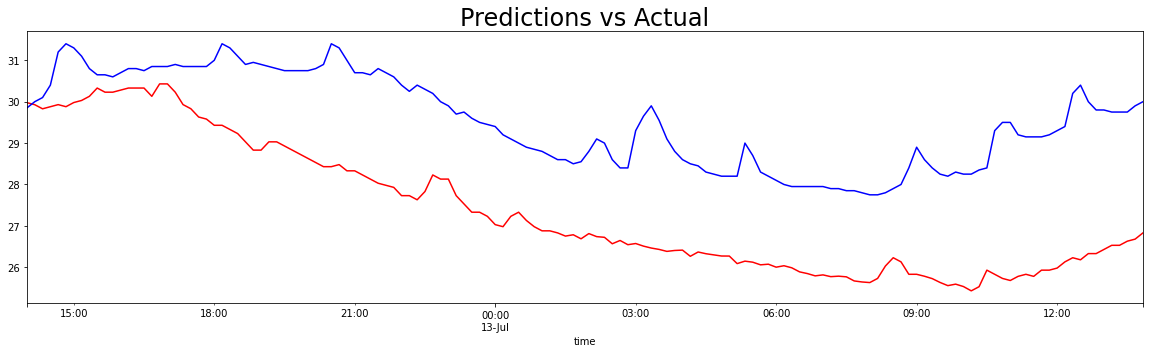

In [20]:
df_pred_t = results_t.predict(start = start_date, end = end_date)

df_pred_t[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [23]:
print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred_t[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred_t[start_date:end_date])))

ABSOLUTE ERROR 2.1459639735896854
MSE 5.347716315300403


In [ ]:
results_t.plot_diagnostics(figsize = (30,20))
plt.show()